In [68]:
# inspired by https://gist.github.com/yanofsky/5436496


'''
@author Manuel Kohler
'''

%matplotlib inline 

import twitter

import tweepy
import csv
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import datetime
from datetime import timezone
from pytz import timezone
from datetime import timedelta
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib
matplotlib.style.use('ggplot')
import json
import os

screen_name = 'realDonaldTrump'
#screen_name = 'rogerfederer'

_count = 200

base_dir = '/Users/kohleman/PycharmProjects/twitter/twitter_api/twitter_api/data/'
raw_data_file = os.path.join(base_dir, 'raw_tweets_{0}.json'.format(screen_name))

# Login to API

auth = OAuthHandler(ckey, csecrect)
auth.set_access_token(atoken, asecret)
api = tweepy.API(auth)


class listener(StreamListener):

    def on_data(self, raw_data):
        print(raw_data)
        return True

    def on_error(self, status_code):
        print(status_code)

        
def extract_json(raw_tweets):
    return [[tweet._json] for tweet in raw_tweets]

In [52]:
# Access current stream
twitterStream = Stream (auth, listener())
#twitterStream.filter(track=["#trump"])

In [56]:
def get_all_tweets(screen_name):
    # taken some code from https://github.com/adilmoujahid/Twitter_Analytics/blob/master/analyze_tweets.py
    #Twitter only allows access to a users most recent 3240 tweets with this method

    #initialize a list to hold all the tweepy Tweets
    alltweets = []

    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = screen_name,count = _count)

    #save most recent tweets
    alltweets.extend(new_tweets)
    
    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1

    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        print("getting tweets before {0}".format(oldest))

        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = screen_name, count = _count, max_id = oldest)

        #save most recent tweets
        alltweets.extend(new_tweets)

        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1

        print("...{0} tweets downloaded so far".format(len(alltweets)))

    #transform the tweepy tweets into a 2D array that will populate the csv	
    outtweets = [[tweet.id_str, tweet.created_at, tweet.text.encode("utf-8")] for tweet in alltweets]
    
    #write the csv
    with open(os.path.join(base_dir, '{0}_all_tweets.csv'.format(screen_name)), 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["id","created_at","text"])
        writer.writerows(outtweets)

    return alltweets
    


In [57]:
alltweets = get_all_tweets(screen_name)

getting tweets before 819863039902097407
...400 tweets downloaded so far
getting tweets before 806214236053667841
...599 tweets downloaded so far
getting tweets before 793824247168765951
...799 tweets downloaded so far
getting tweets before 788925658822868991
...999 tweets downloaded so far
getting tweets before 785302062083047423
...1199 tweets downloaded so far
getting tweets before 780719876335894527
...1399 tweets downloaded so far
getting tweets before 773140953133641728
...1599 tweets downloaded so far
getting tweets before 764552764177481727
...1799 tweets downloaded so far
getting tweets before 758685974637473792
...1999 tweets downloaded so far
getting tweets before 752686998826131455
...2199 tweets downloaded so far
getting tweets before 744701872456536063
...2399 tweets downloaded so far
getting tweets before 737610159459991551
...2599 tweets downloaded so far
getting tweets before 731805331425218559
...2799 tweets downloaded so far
getting tweets before 724772013219405823
.

In [58]:


# Accessing https://dev.twitter.com/rest/reference/get/statuses/user_timeline


# include_rts = include retweets
#new_tweets = api.user_timeline(screen_name = screen_name, count=count, include_rts=True)
# max_id_tweets = api.user_timeline(screen_name = screen_name,count=count, include_rts=True, max_id=818643528905621504)


outtweets = [[tweet.id_str, tweet.created_at, tweet.text.encode("utf-8"), tweet._json] for tweet in alltweets]

json_tweets = extract_json(alltweets)
# older_tweets = extract_json(max_id_tweets)

with open (raw_data_file, 'w') as jsonfile:
    json.dump(json_tweets, jsonfile, ensure_ascii=False, indent=4, separators=(',', ': '))
    json.dump(older_tweets, jsonfile, ensure_ascii=False, indent=4, separators=(',', ': '))
    




Got 3203 tweets


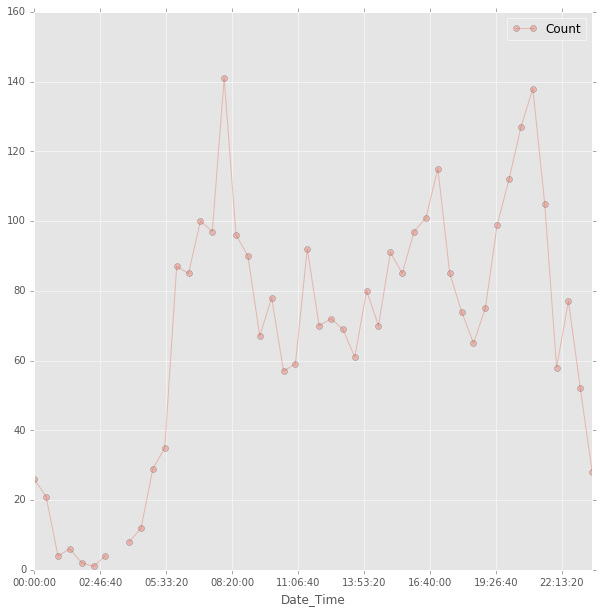

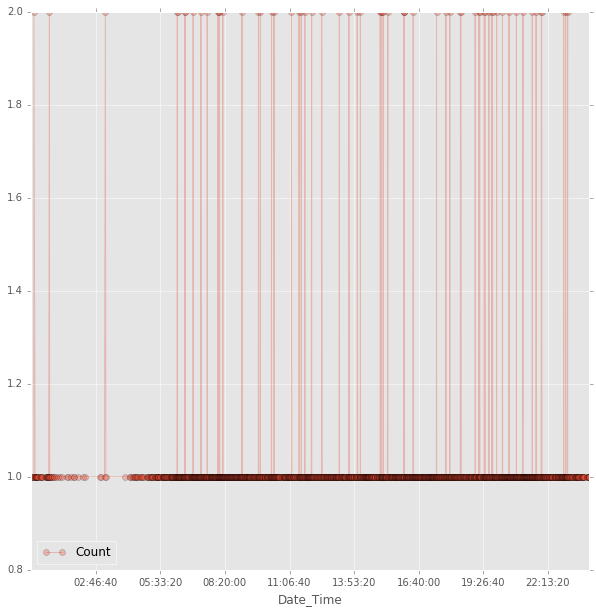

In [65]:
eastern = timezone('US/Eastern')
zurich = timezone('Europe/Zurich')

# Quick day light saving hack
dls = timedelta(seconds=3600)

fmt = '%Y-%m-%d %H:%M:%S %Z%z'
simple_time_format = '%H:%M'
# Used to put all timestamps in one day
one_day_time_format = '2017-01-01 %H:%M:%S'


print("Got {0} tweets".format(len(outtweets)))

dt_series = []

for tweets in outtweets:
    timestamp = tweets[1]
    # print(timestamp)
    loc_dt = zurich.localize(timestamp) + dls
#     print("Localized Zurich Timezone: {0}".format(loc_dt.strftime(fmt)))    
    eastern_dt = loc_dt.astimezone(eastern)
#     print("Localized Eastern Timezone: {0}".format(eastern_dt.strftime(one_day_time_format)))
    
    one_day_dt =datetime.datetime.strptime(eastern_dt.strftime(one_day_time_format), '%Y-%m-%d %H:%M:%S')
    
    dt_series.append(one_day_dt)
    

series = pd.Series(1, index=dt_series)
binned = series.resample('30T').sum()

counted = Counter(dt_series)
values = []

for key, value in dict(counted).items():
    values.append(value)

df2 = pd.DataFrame({ 'Date_Time' : list(counted),
                     'Count' : values})

binned_df = pd.DataFrame({'Date_Time':binned.index, 'Count':binned.values})

# print(binned.index)
# print(binned.values)


# print(binned_df.Date_Time.dt.time)

binned_df.plot.line(x=binned_df.Date_Time.dt.time, y='Count', marker='o', alpha=0.3, figsize=(10,10))


# print(df2.Date_Time.dt.hour)
df2.plot.line(x=df2.Date_Time.dt.time, y='Count', marker='o', alpha=0.3, figsize=(10,10))

# print(df2.Date_Time.dt.time)
# df2.plot.line(x=df2.Date_Time.dt.time)
# ppd = pd.Series(dt_series)
# print(ppd)
    

In [ ]:
list(counted)

In [ ]:
# series = pd.Series(1, index=dt_series)
binned = series.resample('30T').sum()

binned_df = pd.DataFrame({'Date_Time':binned.index, 'Count':binned.values})
print(binned_df)
